In [1]:
#hide
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00


In [2]:
#hide
import warnings
warnings.filterwarnings("ignore")

In [3]:

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm


# compute metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sb

## Loading data


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

In [7]:
df= pd.read_csv("/content/drive/MyDrive/machine/book_authors_vi_2.csv")


In [8]:
df


,text,label
0,Hồ Anh Thái,0
1,Toan Ánh,0
2,Nguyễn Ngọc Tư,0
3,Vương Hồng Sển,0
4,Nguyễn Nhật Ánh,0
...,...,...
1587,Chiến Dịch Giải Cứu Những Vì Sao ...,1
1588,"Kamil - Cậu Bé ""Nhìn"" Mọi Thứ Bằng Tay ...",1
1589,Những Cuộc Phiêu Lưu Của Tom Sawyer ...,1
1590,Cố Chấp Hóa Đau Thương ...,1


In [ ]:
df['label'].value_counts()

In [10]:
df.head(5)

,text,label
0,Hồ Anh Thái,0
1,Toan Ánh,0
2,Nguyễn Ngọc Tư,0
3,Vương Hồng Sển,0
4,Nguyễn Nhật Ánh,0


In [ ]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập train (80%), validation (10%), và test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# In thông tin về kích thước của từng tập dữ liệu
print("Số lượng mẫu trong tập train:", len(train_df))
print("Số lượng mẫu trong tập validation:", len(val_df))
print("Số lượng mẫu trong tập test:", len(test_df))

In [12]:
label_names = train_df['label']
label_names

1545    1
1509    1
744     1
462     0
1356    1
       ..
1130    1
1294    1
860     1
1459    1
1126    1
Name: label, Length: 1273, dtype: int64

Let's take a look at what the text is like:

In [13]:
train_df.head()

,text,label
1545,Bá Tước Monte Cristo ...,1
1509,Phía Trước Là Bầu Trời ...,1
744,Chương Cuối Của Mùa Hạ ...,1
462,Phan Quốc Bảo,0
1356,Thiền ...,1


In [14]:
train_df['label'].value_counts()

1    715
0    558
Name: label, dtype: int64

In [15]:
val_df['label'].value_counts()

1    86
0    73
Name: label, dtype: int64

In [16]:
test_df['label'].value_counts()

0    84
1    76
Name: label, dtype: int64

<br>

## Tokenization

In [17]:
from transformers import BertTokenizer
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

define a function for encoding:

In [18]:
def encode(docs):
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [19]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(val_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

<br>

## Creating `Dataset`s and `DataLoader`s

Turn the labels into tensors:

In [20]:
import torch
train_y = torch.LongTensor(train_df['label'].values.tolist())
val_y = torch.LongTensor(val_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),val_y.size(),test_y.size()

(torch.Size([1273]), torch.Size([159]), torch.Size([160]))

Create dataloaders for training

In [21]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, val_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

<br>

## Bert For Sequence Classification Model

In [22]:
from transformers import BertForSequenceClassification
N_labels = len(train_df['label'].unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
model = model.cuda()

<br>

## Fine-tuning

### **Optimizer and Scheduler**

In [25]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 20
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

<br>

### **Training Loop**

In [26]:

from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(val_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.6476948343217372 
10/10 val loss: 0.4815841943025589 
Epoch:  2


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.46277999598532915 
10/10 val loss: 0.3202185645699501 
Epoch:  3


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.3497642446309328 
10/10 val loss: 0.28550168722867963 
Epoch:  4


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.3065853029489517 
10/10 val loss: 0.25406834706664083 
Epoch:  5


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.2774073944427073 
10/10 val loss: 0.23102469444274903 
Epoch:  6


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.24454244440421463 
10/10 val loss: 0.21032118052244186 
Epoch:  7


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.23251857412979007 
10/10 val loss: 0.20248476043343544 
Epoch:  8


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.21374002709053458 
10/10 val loss: 0.1942298449575901 
Epoch:  9


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.18584202732890845 
10/10 val loss: 0.17330290712416171 
Epoch:  10


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.1926305360160768 
10/10 val loss: 0.1786410640925169 
Epoch:  11


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.18886113569606094 
10/10 val loss: 0.1593482308089733 
Epoch:  12


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.17133987678680568 
10/10 val loss: 0.19063318390399217 
Epoch:  13


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.17914763831067831 
10/10 val loss: 0.1549319051206112 
Epoch:  14


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.14798841739539056 
10/10 val loss: 0.15238045370206238 
Epoch:  15


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.15563578106230125 
10/10 val loss: 0.1753764210268855 
Epoch:  16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.1620009653037414 
10/10 val loss: 0.1482884857803583 
Epoch:  17


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.14253742883447557 
10/10 val loss: 0.14793704617768527 
Epoch:  18


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.14232035878812893 
10/10 val loss: 0.15429611997678877 
Epoch:  19


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.14009077304508538 
10/10 val loss: 0.15129286991432309 
Epoch:  20


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

80/80 train loss: 0.14751863083802164 
10/10 val loss: 0.15407729819417 


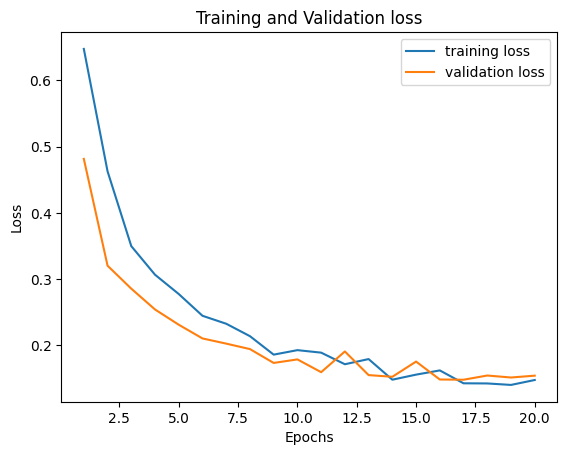

In [27]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Performance Metrics
It's common to use precision, recall, and F1-score as the performance metrics.

In [28]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, val_df['label'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        75
           1       0.95      0.98      0.96        84

    accuracy                           0.96       159
   macro avg       0.96      0.96      0.96       159
weighted avg       0.96      0.96      0.96       159



## Error Analysis

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

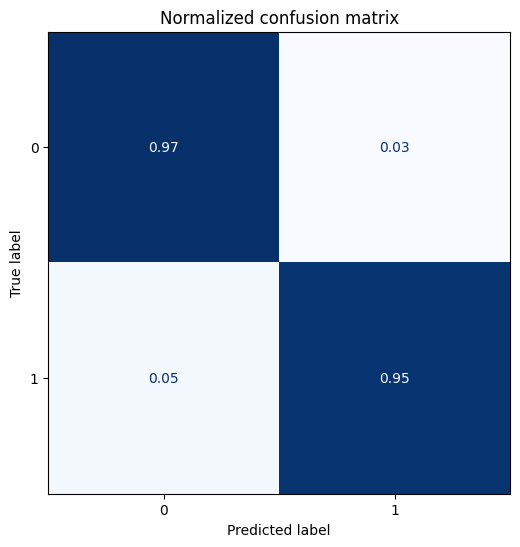

In [30]:
plot_confusion_matrix(valid_pred,val_df['label'].to_numpy())

<br>

## Prediction

In [31]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [32]:
print('classifiation report')
print(classification_report(test_pred, test_df['label'].to_numpy()))

classifiation report
              precision    recall  f1-score   support

           0       0.94      0.93      0.93        85
           1       0.92      0.93      0.93        75

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.93       160
weighted avg       0.93      0.93      0.93       160



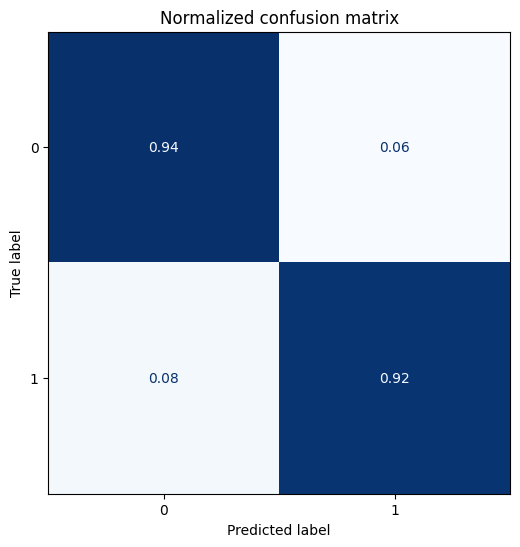

In [33]:
plot_confusion_matrix(test_pred,test_df['label'].to_numpy())

Output the misclassified text:

In [34]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

(11, 3)


,text,label,pred
832,Bố Già ...,1,0
1401,Chiếc Thìa Bạc ...,1,0
251,Tư Mã An,0,1
344,Từ Thế Vĩ,0,1
371,Hội chăn nuôi Việt Nam,0,1
1316,Đế Vương Công Lượ-3) ...,1,0
275,Nhà xuất bản Chính trị quốc gia,0,1
793,Tự Bốc Cháy ...,1,0
963,Điệu Foxtrot Thượng Hải ...,1,0
1398,The Outsider - Kẻ Song Trùng ...,1,0


In [35]:
# Đường dẫn đến nơi bạn muốn lưu mô hình
save_path = '/content/model2.pth'

# Lưu mô hình
torch.save(model.state_dict(), save_path)

# In thông báo lưu thành công
print(f'Mô hình đã được lưu tại: {save_path}')

Mô hình đã được lưu tại: /content/model2.pth


DEMO